<a href="https://colab.research.google.com/github/Mobashra/Comparison-of-Enhancement-Techniques-on-Microstructure-Images-for-Crack-Detection/blob/main/CSE428.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing Necessary Libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from PIL import Image
import os
from os import listdir
import shutil
from google.colab.patches import cv2_imshow 
import warnings
from skimage import io, transform, img_as_float
from skimage import io, color, exposure
import glob
from google.colab import drive
from skimage import io
from sklearn.metrics import classification_report,confusion_matrix
import math
import cv2 as cv
import numpy.ma as ma
import skimage.measure 
warnings.filterwarnings('ignore')

### **Mount Drive**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### **Other Histogram Techniques**

In [3]:
class Utils:
	def __init__(self, image, color_space = 'HSV'):
		self.image = image
		self.color_space = color_space

	def image_gray(self):
		if (self.color_space == 'HSV'):
			image_hsv = cv.cvtColor(self.image, cv.COLOR_BGR2HSV)
			self.image_color = image_hsv

			return image_hsv[:, :, 2]
		elif (self.color_space == 'Gray'):
			image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
			self.image_color = image_gray

			return image_gray
		else:
			self.image_color = self.image
			return self.image

	def LUT_image(self, LUT):
		if (self.color_space == 'HSV'):
			for i in range(0, len(self.image_color)):
				for j in range(0, len(self.image_color[0])):
					self.image_color[i][j][2] = LUT[self.image_color[i][j][2]]

			return cv.cvtColor(self.image_color, cv.COLOR_HSV2BGR)
		elif (self.color_space == 'Gray'):
			return LUT[self.image_color]
		else:
			return self.image_color

	def is_gray_image(self):
		blue, gree, red = cv2.split(self.image)

		difference_red_green = np.count_nonzero(abs(red - green))
		difference_green_blue = np.count_nonzero(abs(green - blue))
		difference_blue_red = np.count_nonzero(abs(blue - red))

		difference_sum = float(difference_red_green + difference_green_blue + difference_blue_red)

		ratio = diff_sum / self.image.size

		if ratio>0.005:
				return False
		else:
				return True

	def minimum_mean_brightness_error(self, image_1d):
		length = len(image_1d)

		unique_1d = np.unique(image_1d)
		max_1d = len(unique_1d)

		histogram, _ = np.histogram(image_1d, 256, [0, 255])

		mean = 0
		for i in range(0, len(unique_1d)):
			mean += i * histogram[unique_1d[i]]

		smbe = max_1d * (length - histogram[unique_1d[0]]) - 2 * mean
		asmbe = abs(smbe)
		position = 0
		for i in range(1, len(unique_1d)):
			smbe += (length - max_1d * histogram[unique_1d[i]])
			if asmbe > abs(smbe):
				asmbe = abs(smbe)
				position = i

		return unique_1d[position]

	
	

def RGB_TO_HSI(image):
	with np.errstate(divide='ignore', invalid='ignore'):
		#Load image with 32 bit floats as variable type
		bgr = np.float32(img) / 255

		#Separate color channels
		blue = bgr[:,:,0]
		green = bgr[:,:,1]
		red = bgr[:,:,2]

		minimum = np.minimum(np.minimum(red, green), blue)
		maximum = np.maximum(np.maximum(red, green), blue)
		delta = maximum - minimum

		intensity = np.divide(blue + green + red, 3)

		if intensity == 0:
			saturation = 0
		else:
			saturation = 1 - 3 * np.divide(minimum, red + green + blue)

		sqrt_calc = np.sqrt(((red - green) * (red - green)) + ((red - blue) * (green - blue)))
		if (green >= blue).any():
			hue = np.arccos((1 / 2 * ((red-green) + (red - blue)) / sqrt_calc))
		else:
			hue = 2 * math.pi - np.arccos((1 / 2 * ((red-green) + (red - blue)) / sqrt_calc))

		hue = hue * 180 / math.pi

		#Merge channels into picture and return image
		hsi = cv2.merge((intensity, saturation, hue))
		return hsi

def pdf(image, parameter = 'HSI'):
	if parameter == 'GRAY':
		image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
		image_1d = image_gray.flatten()
		
		histogram, _ = np.histogram(image_1d, 256, [0, 256])
	elif parameter == 'INTENSITY':
		image_hsi = RGB_TO_HSI(image)

		intensity = image_hsi[:, :, 0]
		intensity_1d = intensity.flatten()

	return histogram


In [4]:
class Histogram:

	def cdf_matching(self, input_cdf, output_cdf):
		ratio = input_cdf[255] / output_cdf[255]
		output_cdf = output_cdf * ratio

		LUT = np.array([])
		position_new = 0
		for i in range(0, 256):
			while output_cdf[position_new] < input_cdf[i]:
				position_new += 1
			
			LUT = np.append(LUT, position_new)

		return LUT

	def histogram_specification(self, input_histogram, output_histogram):
		input_cdf = input_histogram.cumsum()
		output_cdf = output_histogram.cumsum()
		
		return self.cdf_matching(input_cdf, output_cdf)

	def sub_histogram_equalization(self, histogram, range_min = 0, range_max = 255):
		cdf = histogram.cumsum()
		cdf_mask = np.ma.masked_equal(cdf, 0)

		# Scale cdf to [range_min, range_max]
		scale_cdf_mask = ((cdf_mask - cdf_mask.min()) * (range_max - range_min) / (cdf_mask.max() - cdf_mask.min())) + range_min
		LUT = np.ma.filled(scale_cdf_mask, 0).astype('uint8')

		return LUT

	def histogram_equalization(self, image_1d, range_min = 0, range_max = 255):
		histogram, _ = np.histogram(image_1d, range_max - range_min + 1, [range_min, range_max])

		return self.sub_histogram_equalization(histogram, range_min, range_max)

	def histogram_equalization_threshold(self, image_1d, threshold, start = 0, end = 255):
		lower_filter = image_1d <= threshold
		lower_1d = image_1d[lower_filter]

		upper_filter = image_1d > threshold
		upper_1d = image_1d[upper_filter]

		lower_input_lut = np.array([])
		if start > 0:
			for i in range(0, start):
				lower_input_lut = np.append(lower_input_lut, i)

		upper_input_lut = np.array([])
		if end < 255:
			for i in range(end + 1, 256):
				upper_input_lut = np.append(upper_input_lut, i)

		lower_LUT = self.histogram_equalization(lower_1d, start, threshold)
		upper_LUT = self.histogram_equalization(upper_1d, threshold + 1, end)

		lower_LUT = np.concatenate((lower_input_lut, lower_LUT))
		upper_LUT = np.concatenate((upper_LUT, upper_input_lut))

		LUT = np.concatenate((lower_LUT, upper_LUT))

		return LUT

	def histogram_equalization_recursively(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_equalization_recursively(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_equalization_recursively(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return np.concatenate((lower_equalization, upper_equalization))
		else:
			return self.histogram_equalization(image_1d, start, end)

	def histogram_segmentation(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_segmentation(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_segmentation(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return lower_equalization + upper_equalization
		else:
			sub_histogram, _ = np.histogram(image_1d, end - start + 1, [start, end])
			return [sub_histogram]


In [5]:
class IE:
    def __init__(self, image, color_space = 'HSV'):
        self.image = image
        self.color_space = color_space



    # Kim, Yeong-Taeg.
    # Contrast enhancement using brightness preserving bi-histogram equalization. 
    # IEEE transactions on Consumer Electronics 43, no. 1 (1997): 1-8.
    # Brightness-preserving Bi-Histogram Equalization (BBHE)
    def BBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mean = np.mean(image_1d)
        mean = math.floor(mean)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mean)
        return utils.LUT_image(LUT)



    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Contrast enhancement using recursive mean-separate histogram equalization for scalable brightness preservation.
    # IEEE Transactions on consumer Electronics 49, no. 4 (2003): 1301-1309.
    # Recursive Mean-Separate Histogram Equalization (RMSHE)
    def RMSHE(self, recursive = 2):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization_recursively(image_1d, np.mean, recursive)
        return utils.LUT_image(LUT)


    # Wang, Qing, and Rabab K. Ward. 
    # Fast image/video contrast enhancement based on weighted thresholded histogram equalization.
    # IEEE transactions on Consumer Electronics 53, no. 2 (2007): 757-764.
    # Weighted Thresholded Histogram Equalization (WTHE)
    def WTHE(self, root = 0.5, value = 0.5, lower = 0):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()
        length = len(image_1d)

        pdf, _ = np.histogram(image_1d, 256, [0, 255])
        pdf = pdf / length

        if value < 1:
            upper = pdf.max() * value
        else:
            upper = pdf.max()

        weight_pdf = np.array([0.0] * 256)
        for i in range(0, 256):
            if pdf[i]  < lower:
                weight_pdf[i] = 0
            elif pdf[i] < upper:
                weight_pdf[i] = upper * ((pdf[i] - lower) / (upper - lower)) ** root
            else:
                weight_pdf[i] = upper

        weight_pdf_sum = np.sum(weight_pdf)
        weight_pdf_scale = weight_pdf / weight_pdf_sum

        histogram = Histogram()
        LUT = histogram.sub_histogram_equalization(weight_pdf_scale)
        return utils.LUT_image(LUT)


### **Sample Image**

(-0.5, 226.5, 226.5, -0.5)

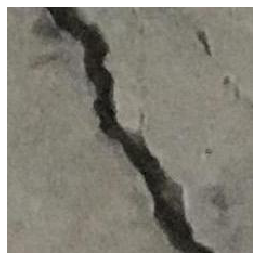

In [6]:
image=io.imread('/content/drive/MyDrive/CSE428 dataset/sample.jpg')
io.imshow(image)
plt.axis("off")

## **Histogram and cdf of sample image**

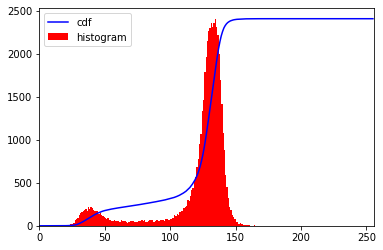

In [7]:
img = cv2.imread('/content/drive/MyDrive/CSE428 dataset/sample.jpg',0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

## **Histogram Equalization on sample image**

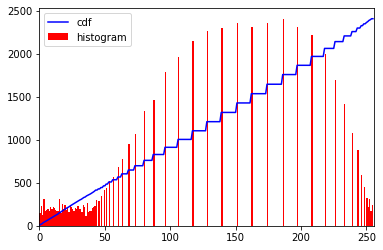

In [32]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]
hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### **Code for plotting histogram and image**

In [8]:
def plot_hist(I, nbins=256, normalize=True, plot_cdf=True):
    hist, bins_hist = exposure.histogram(I.ravel(), nbins=nbins, normalize=normalize)
    plt.plot(bins_hist, hist, 'k')
    plt.xlabel("pixel values")
    if normalize:
        plt.ylabel("probability")
    else:
        plt.ylabel("count")
    xmax = 1 if I.max() <= 1 else 255
    plt.xlim([0, xmax])
    
    if plot_cdf:
        cdf, bins_cdf = exposure.cumulative_distribution(I.ravel(), nbins=256)
        plt.twinx()
        plt.plot(bins_cdf, cdf, 'r', lw=3)
        plt.ylabel("percentage")

def plot_img_and_hist(I, nbins=256, normalize=False, plot_cdf=True):
    plt.subplot(2, 1, 1)
    io.imshow(I)
    plt.axis("off")
    plt.title("image")
    
    plt.subplot(2, 1, 2)
    plot_hist(I, nbins=nbins, normalize=normalize, plot_cdf=plot_cdf)
    plt.title("histogram")


## **Application of AHE on sample image**

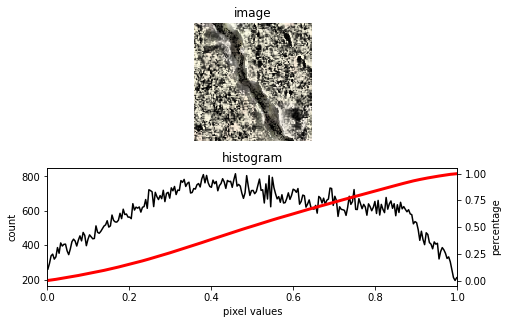

In [12]:
image = io.imread("/content/drive/MyDrive/CSE428 dataset/sample.jpg")

Image_AHE = exposure.equalize_adapthist(image, kernel_size=(25, 25), clip_limit=0)
plot_img_and_hist(Image_AHE)



## **Application of CLAHE on sample image**

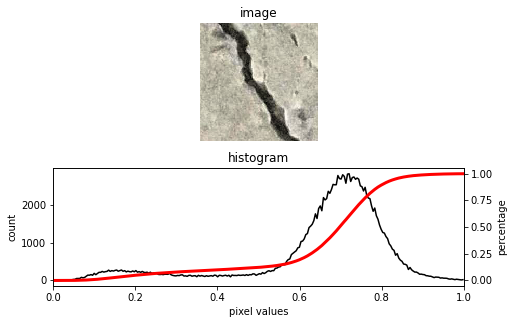

In [13]:
Image_CLAHE = exposure.equalize_adapthist(image, kernel_size=(25, 25), clip_limit=0.01)

plot_img_and_hist(Image_CLAHE)


## **Application of BBHE on sample image**

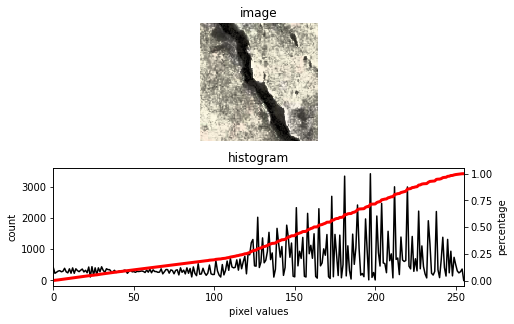

In [14]:
bbhe = IE(image)
im_bbhe = bbhe.BBHE()

plot_img_and_hist(im_bbhe)

## **Application of RMSHE on sample image**

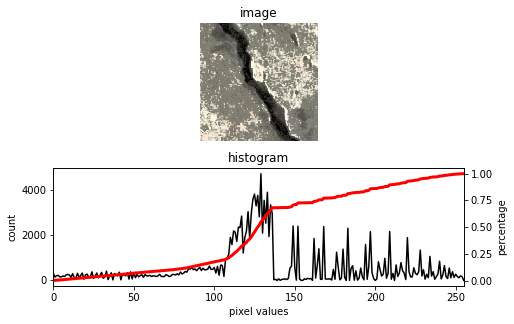

In [15]:
rmshe = IE(image)
im_rmshe = rmshe.RMSHE()

plot_img_and_hist(im_rmshe)

## **Application of WTHE on sample image**

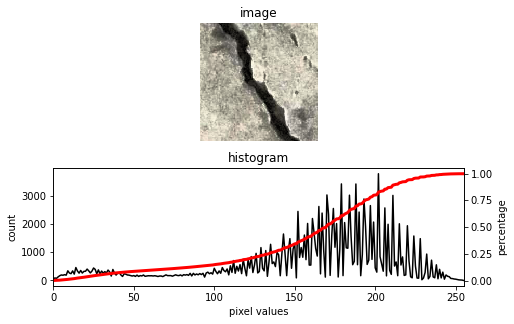

In [16]:
wthe = IE(image)
im_wthe = wthe.WTHE()

plot_img_and_hist(im_wthe)

### **Calculation of Mean Squared Error**

In [17]:
def mse(image, Image_CLAHE):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((image.astype("float") - Image_CLAHE.astype("float")) ** 2)
    err /= float(image.shape[0] * image.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [18]:
print("MSE of AHE:", mse(image,Image_AHE))
print("MSE of CLAHE:", mse(image,Image_CLAHE))
print("MSE of BBHE:", mse(image,im_bbhe))
print("MSE of WTHE:", mse(image,im_wthe))
print("MSE of RMSHE:", mse(image,im_rmshe))

MSE of AHE: 43693.370837430186
MSE of CLAHE: 43578.227731167935
MSE of BBHE: 8933.597857517127
MSE of WTHE: 7120.498787090764
MSE of RMSHE: 4025.848881212521


### **Entropy calculation**

In [19]:
entropy = skimage.measure.shannon_entropy(image)
print("Entropy of original image:",entropy)

Entropy of original image: 6.039613670199743


In [20]:
entropy_ahe = skimage.measure.shannon_entropy(Image_AHE)
entropy_clahe = skimage.measure.shannon_entropy(Image_CLAHE)
entropy_bbhe = skimage.measure.shannon_entropy(im_bbhe)
entropy_wthe = skimage.measure.shannon_entropy(im_wthe)
entropy_rmshe = skimage.measure.shannon_entropy(im_rmshe)

print("Entropy of AHE:",entropy_ahe)
print("Entropy of CLAHE:",entropy_clahe)
print("Entropy of BBHE:",entropy_bbhe)
print("Entropy of WTHE:",entropy_wthe)
print("Entropy of RMSHE:",entropy_rmshe)

Entropy of AHE: 16.408329626329113
Entropy of CLAHE: 15.873026101207182
Entropy of BBHE: 7.4372719997378685
Entropy of WTHE: 7.2267875355896525
Entropy of RMSHE: 6.961880209392938


### **Loading all images**

In [21]:
labels = ['Negative', 'Positive']
img_size = 120
#i = 0
def read_images(data_dir):
    i=0
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
                i+=1
                if i == 1000:
                  i = 0
                  break
                
            except Exception as e:
                print(e)

          
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



### **Visualising Dataset**

Text(0.5, 1.0, 'Number of Images')

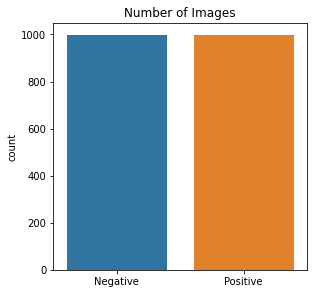

In [22]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("Negative")
    elif(i[1] == 1):
        Im.append("Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

## **CLAHE**

In [45]:
labels = ['Negative', 'Positive']
img_size = 120
def read_images(data_dir):
    data = [] 
    i=0
    for label in labels: 
        error = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                Image_CLAHE = exposure.equalize_adapthist(resized_arr, kernel_size=(25, 25), clip_limit=0.01)
                error = error + mse(resized_arr,Image_CLAHE)
                filename = "/content/drive/MyDrive/CSE428 dataset/Clahe_"+label+"/"+str(i)+".jpg"
                plt.imsave(filename,Image_CLAHE)
                data.append([Image_CLAHE, class_num])
                i+=1
                
                if i == 1000:
                  avg_error = error/i
                  print("MSE",label,avg_error)
                  i=0
                  break
                
            except Exception as e:
                print(e)
                
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

MSE Negative 98169.0567145239
MSE Positive 71333.25476478996


In [46]:
x = []
y = []

for feature, label in Dataset:
    x.append(feature)
    y.append(label)

x = np.array(x)
print(len(x))
y = np.array(y)
print(len(y))

In [47]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

Text(0.5, 1.0, 'Number of Images')

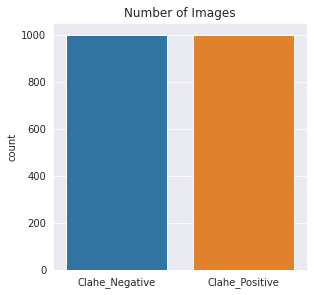

In [48]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("Clahe_Negative")
    elif(i[1] == 1):
        Im.append("Clahe_Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

In [49]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x,y, epochs = 15, batch_size = 128, validation_split = 0.25, verbose=1)

Epoch 1/15
12/12 [==============================] - 50s 4s/step - loss: 0.7788 - accuracy: 0.5327 - val_loss: 0.6425 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 48s 4s/step - loss: 0.6478 - accuracy: 0.6307 - val_loss: 0.6008 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 52s 4s/step - loss: 0.5812 - accuracy: 0.6920 - val_loss: 0.6201 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 47s 4s/step - loss: 0.5004 - accuracy: 0.7720 - val_loss: 0.6315 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 51s 4s/step - loss: 0.4625 - accuracy: 0.8153 - val_loss: 0.6460 - val_accuracy: 0.9680
Epoch 6/15
12/12 [==============================] - 48s 4s/step - loss: 0.4217 - accuracy: 0.8420 - val_loss: 0.6287 - val_accuracy: 0.9840
Epoch 7/15
12/12 [==============================] - 52s 4s/step - loss: 0.3964 - accuracy: 0.8680 - val_loss: 0.6338 - val_accuracy: 0.9480
Epoch 8/15
12/12 [==

In [50]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


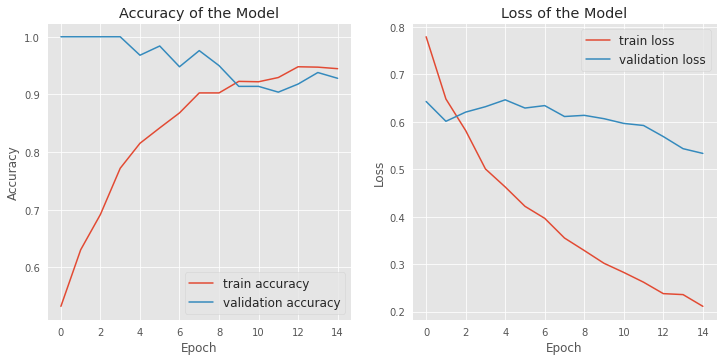

In [51]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [52]:
predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

print('Confusion Matrix:\n',confusion_matrix(y,classes_x))
print(classification_report(y, classes_x, target_names = ['Clahe_Negative','Clahe_Positive']))

Confusion Matrix:
 [[965  35]
 [ 59 941]]
                precision    recall  f1-score   support

Clahe_Negative       0.94      0.96      0.95      1000
Clahe_Positive       0.96      0.94      0.95      1000

      accuracy                           0.95      2000
     macro avg       0.95      0.95      0.95      2000
  weighted avg       0.95      0.95      0.95      2000



## **AHE**

In [53]:
labels = ['Negative', 'Positive']
img_size = 120
def read_images(data_dir):
    data = [] 
    i=0
    for label in labels: 
        error = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                Image_AHE = exposure.equalize_adapthist(resized_arr, kernel_size=(25, 25), clip_limit=0)
                error = error + mse(resized_arr,Image_AHE)
                filename = "/content/drive/MyDrive/CSE428 dataset/Ahe_"+label+"/"+str(i)+".jpg"
                plt.imsave(filename,Image_AHE)
                data.append([Image_AHE, class_num])
                i+=1
                
                if i == 1000:
                  avg_error = error/i
                  print("MSE",label,avg_error)
                  i=0
                  break
                
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

MSE Negative 98228.20687937809
MSE Positive 71452.88755466997


Text(0.5, 1.0, 'Number of Images')

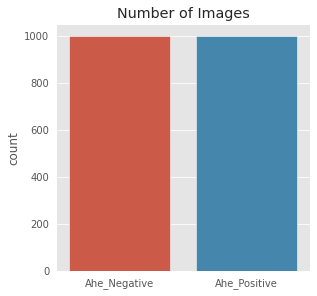

In [54]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("Ahe_Negative")
    elif(i[1] == 1):
        Im.append("Ahe_Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

In [55]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)     

In [56]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x,y, epochs = 15, batch_size = 128, validation_split = 0.25, verbose=1)

Epoch 1/15
12/12 [==============================] - 49s 4s/step - loss: 0.7624 - accuracy: 0.5393 - val_loss: 0.6064 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 43s 4s/step - loss: 0.6302 - accuracy: 0.6440 - val_loss: 0.5854 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 44s 4s/step - loss: 0.5757 - accuracy: 0.7060 - val_loss: 0.5938 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 45s 4s/step - loss: 0.5377 - accuracy: 0.7413 - val_loss: 0.5938 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 43s 4s/step - loss: 0.4666 - accuracy: 0.8180 - val_loss: 0.5988 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 45s 4s/step - loss: 0.4229 - accuracy: 0.8460 - val_loss: 0.6240 - val_accuracy: 0.9960
Epoch 7/15
12/12 [==============================] - 45s 4s/step - loss: 0.3888 - accuracy: 0.8800 - val_loss: 0.6271 - val_accuracy: 0.9820
Epoch 8/15
12/12 [==

In [57]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


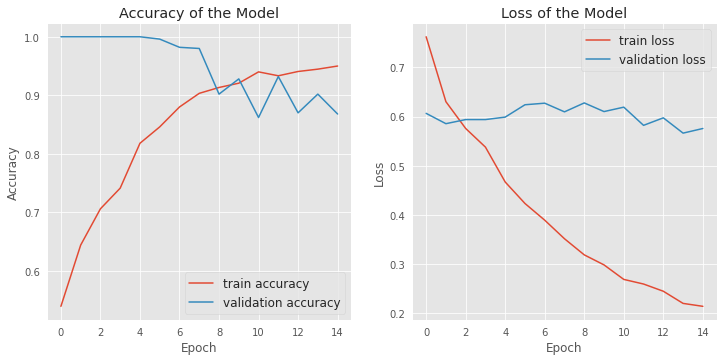

In [58]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [59]:
predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

print('Confusion Matrix:\n',confusion_matrix(y,classes_x))
print(classification_report(y, classes_x, target_names = ['Ahe_Negative','Ahe_Positive']))

Confusion Matrix:
 [[991   9]
 [116 884]]
              precision    recall  f1-score   support

Ahe_Negative       0.90      0.99      0.94      1000
Ahe_Positive       0.99      0.88      0.93      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



## **BBHE**

In [60]:
labels = ['Negative', 'Positive']
img_size = 120
def read_images(data_dir):
    data = [] 
    i=0
    for label in labels: 
        error = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                bbhe = IE(resized_arr)
                Image_CLAHE = bbhe.BBHE()
                error = error+mse(resized_arr,Image_CLAHE) 
                
                filename = "/content/drive/MyDrive/CSE428 dataset/bbhe_"+label+"/"+str(i)+".jpg"
                plt.imsave(filename,Image_CLAHE)
                data.append([Image_CLAHE, class_num])
                i+=1
                
                if i == 1000:
                  avg_error = error/i
                  print("MSE",label,avg_error)
                  i=0
                  break
                
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

MSE Negative 13994.727644999994
MSE Positive 6041.365390138881


Text(0.5, 1.0, 'Number of Images')

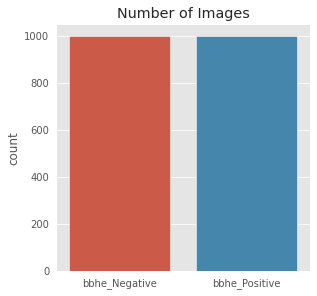

In [61]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("bbhe_Negative")
    elif(i[1] == 1):
        Im.append("bbhe_Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

In [62]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 128)     

In [63]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x,y, epochs = 15, batch_size = 128, validation_split = 0.25, verbose=1)

Epoch 1/15
12/12 [==============================] - 46s 4s/step - loss: 0.7628 - accuracy: 0.5320 - val_loss: 0.6388 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 46s 4s/step - loss: 0.6125 - accuracy: 0.6740 - val_loss: 0.6208 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 44s 4s/step - loss: 0.5556 - accuracy: 0.7300 - val_loss: 0.6132 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 45s 4s/step - loss: 0.4809 - accuracy: 0.8027 - val_loss: 0.6159 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 43s 4s/step - loss: 0.4518 - accuracy: 0.8307 - val_loss: 0.6267 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 43s 4s/step - loss: 0.4049 - accuracy: 0.8493 - val_loss: 0.6356 - val_accuracy: 0.9620
Epoch 7/15
12/12 [==============================] - 44s 4s/step - loss: 0.3624 - accuracy: 0.8913 - val_loss: 0.6228 - val_accuracy: 0.9660
Epoch 8/15
12/12 [==

In [64]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


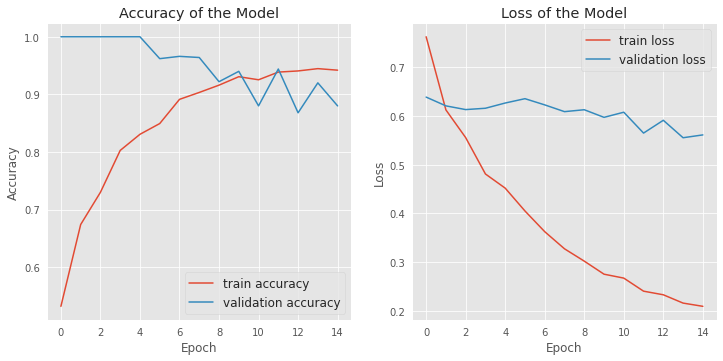

In [65]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [66]:
from sklearn.metrics import classification_report,confusion_matrix


predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

print('Confusion Matrix:\n',confusion_matrix(y,classes_x))
print(classification_report(y, classes_x, target_names = ['BBHE_Negative','BBHE_Positive']))

Confusion Matrix:
 [[986  14]
 [ 96 904]]
               precision    recall  f1-score   support

BBHE_Negative       0.91      0.99      0.95      1000
BBHE_Positive       0.98      0.90      0.94      1000

     accuracy                           0.94      2000
    macro avg       0.95      0.95      0.94      2000
 weighted avg       0.95      0.94      0.94      2000



## **WTHE**

In [67]:
labels = ['Negative', 'Positive']
img_size = 120
def read_images(data_dir):
    data = [] 
    i=0
    for label in labels: 
        error = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                wthe = IE(resized_arr)
                Image_CLAHE = wthe.WTHE()
                error = error+mse(resized_arr,Image_CLAHE) 
                
                filename = "/content/drive/MyDrive/CSE428 dataset/wthe_"+label+"/"+str(i)+".jpg"
                plt.imsave(filename,Image_CLAHE)
                data.append([Image_CLAHE, class_num])
                i+=1
                
                if i == 1000:
                  avg_error = error/i
                  print("MSE",label,avg_error)
                  i=0
                  break
                
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

MSE Negative 13703.482481041654
MSE Positive 3842.973664930552


Text(0.5, 1.0, 'Number of Images')

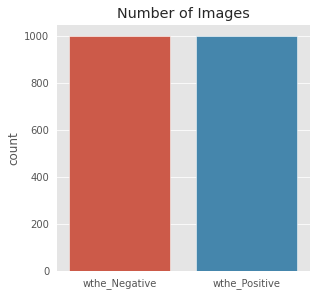

In [68]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("wthe_Negative")
    elif(i[1] == 1):
        Im.append("wthe_Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

In [69]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 128)     

In [70]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x,y, epochs = 15, batch_size = 128, validation_split = 0.25, verbose=1)

Epoch 1/15
12/12 [==============================] - 45s 4s/step - loss: 0.7825 - accuracy: 0.5173 - val_loss: 0.5723 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 43s 4s/step - loss: 0.6746 - accuracy: 0.6067 - val_loss: 0.5470 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 44s 4s/step - loss: 0.5840 - accuracy: 0.6967 - val_loss: 0.5429 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 43s 4s/step - loss: 0.5394 - accuracy: 0.7373 - val_loss: 0.5568 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 43s 4s/step - loss: 0.4827 - accuracy: 0.7793 - val_loss: 0.6071 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 47s 4s/step - loss: 0.4362 - accuracy: 0.8220 - val_loss: 0.6272 - val_accuracy: 0.9960
Epoch 7/15
12/12 [==============================] - 44s 4s/step - loss: 0.3919 - accuracy: 0.8687 - val_loss: 0.6193 - val_accuracy: 0.9900
Epoch 8/15
12/12 [==

In [71]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


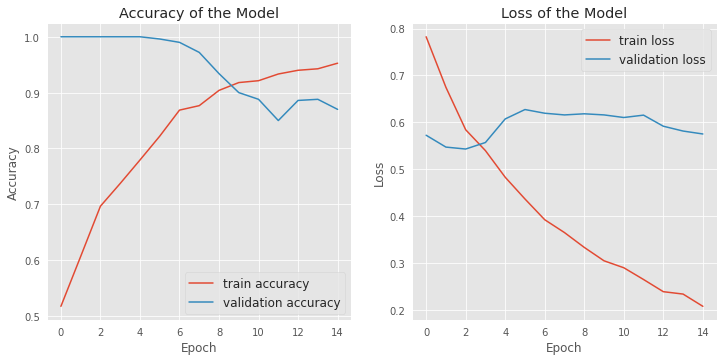

In [72]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [73]:
from sklearn.metrics import classification_report,confusion_matrix


predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

print('Confusion Matrix:\n',confusion_matrix(y,classes_x))
print(classification_report(y, classes_x, target_names = ['WTHE_Negative','WTHE_Positive']))

Confusion Matrix:
 [[993   7]
 [133 867]]
               precision    recall  f1-score   support

WTHE_Negative       0.88      0.99      0.93      1000
WTHE_Positive       0.99      0.87      0.93      1000

     accuracy                           0.93      2000
    macro avg       0.94      0.93      0.93      2000
 weighted avg       0.94      0.93      0.93      2000



## **RMSHE**


In [74]:
labels = ['Negative', 'Positive']
img_size = 120
def read_images(data_dir):
    data = [] 
    i=0
    for label in labels: 
        error = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                rmshe = IE(resized_arr)
                Image_RMSHE = rmshe.RMSHE()
                error = error+mse(resized_arr,Image_RMSHE) 
                
                filename = "/content/drive/MyDrive/CSE428 dataset/RMSHE_"+label+"/"+str(i)+".jpg"
                plt.imsave(filename,Image_RMSHE)
                data.append([Image_RMSHE, class_num])
                i+=1
                
                if i == 1000:
                  avg_error = error/i
                  print("MSE",label,avg_error)
                  i=0
                  break
                
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/CSE428 dataset')

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

MSE Negative 5049.013508888891
MSE Positive 1843.871857916666


Text(0.5, 1.0, 'Number of Images')

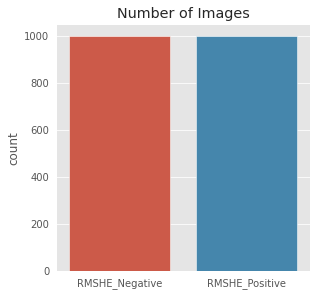

In [75]:
Im = []
for i in Dataset:
    if(i[1] == 0):
        Im.append("RMSHE_Negative")
    elif(i[1] == 1):
        Im.append("RMSHE_Positive")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.set_style('darkgrid')
axl = sns.countplot(Im)
axl.set_title("Number of Images")

In [76]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 128)     

In [77]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x,y, epochs = 15, batch_size = 128, validation_split = 0.25, verbose=1)

Epoch 1/15
12/12 [==============================] - 46s 4s/step - loss: 0.7880 - accuracy: 0.5313 - val_loss: 0.5407 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 44s 4s/step - loss: 0.6658 - accuracy: 0.6187 - val_loss: 0.4946 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 44s 4s/step - loss: 0.5918 - accuracy: 0.6867 - val_loss: 0.5043 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 45s 4s/step - loss: 0.5547 - accuracy: 0.7287 - val_loss: 0.5594 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 43s 4s/step - loss: 0.5196 - accuracy: 0.7680 - val_loss: 0.5635 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 44s 4s/step - loss: 0.4927 - accuracy: 0.7820 - val_loss: 0.5846 - val_accuracy: 1.0000
Epoch 7/15
12/12 [==============================] - 45s 4s/step - loss: 0.4628 - accuracy: 0.8187 - val_loss: 0.5891 - val_accuracy: 1.0000
Epoch 8/15
12/12 [==

In [78]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


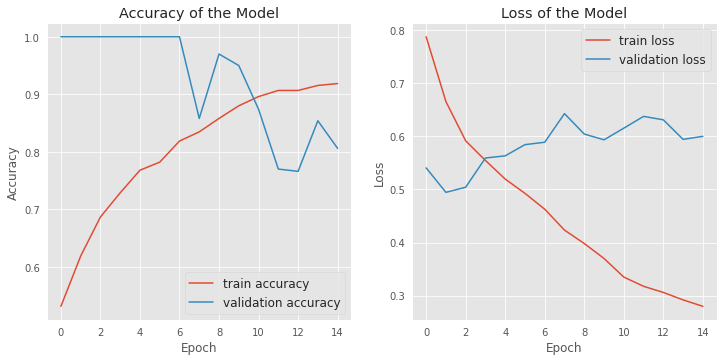

In [79]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [80]:
from sklearn.metrics import classification_report,confusion_matrix


predict_x=model.predict(x) 
classes_x=np.argmax(predict_x,axis=1)

print('Confusion Matrix:\n',confusion_matrix(y,classes_x))
print(classification_report(y, classes_x, target_names = ['RMSHE_Negative','RMSHE_Positive']))

Confusion Matrix:
 [[996   4]
 [213 787]]
                precision    recall  f1-score   support

RMSHE_Negative       0.82      1.00      0.90      1000
RMSHE_Positive       0.99      0.79      0.88      1000

      accuracy                           0.89      2000
     macro avg       0.91      0.89      0.89      2000
  weighted avg       0.91      0.89      0.89      2000



## **MODEL**

In [81]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 38.9 MB/s 


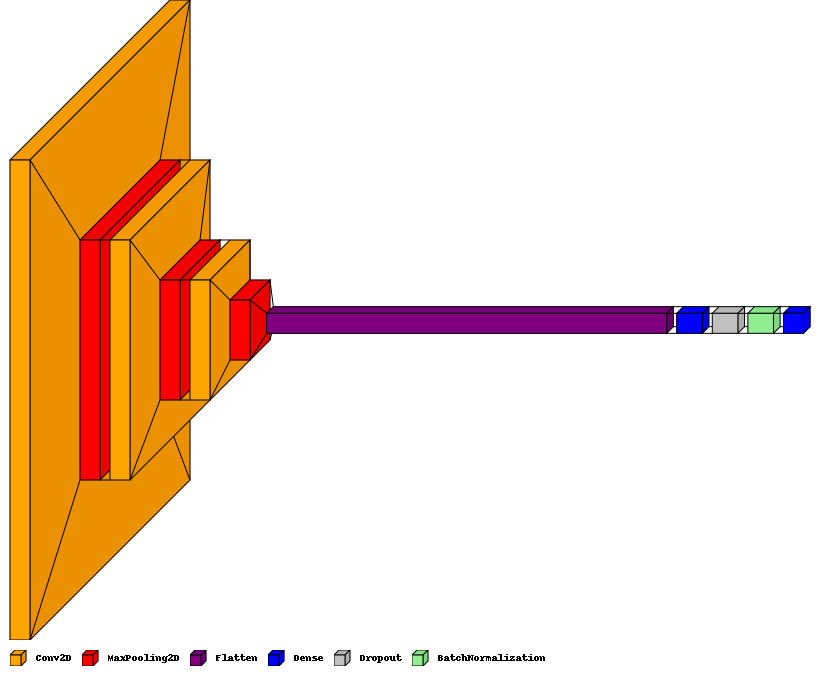

In [82]:
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.load_default()

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'silver'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'blue'
color_map[Flatten]['fill'] = 'purple'
color_map[BatchNormalization]['fill'] = 'lightgreen'

import visualkeras
visualkeras.layered_view(model, legend=True,font=font,color_map=color_map)